In [2]:
import os
import random
import shutil

In [2]:
import os
import shutil
import random

# Set your base dataset path
base_dir = 'EuroSAT_RGB'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
split_ratio = 0.2  # 20% for testing

# 1. Remove any existing train/test folders to start fresh
for folder in [train_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# 2. Get all class folders in base_dir (ignore train/test if present)
all_classes = [d for d in os.listdir(base_dir)
               if os.path.isdir(os.path.join(base_dir, d)) and d not in ['train', 'test']]

# 3. Create clean train/test folders
for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
    for class_name in all_classes:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

# 4. Move and split the images
for class_name in all_classes:
    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)
    split_idx = int(len(images) * (1 - split_ratio))
    train_imgs = images[:split_idx]
    test_imgs = images[split_idx:]

    # Move images to train
    for img in train_imgs:
        shutil.move(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    # Move images to test
    for img in test_imgs:
        shutil.move(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

    # Remove empty original class folder
    os.rmdir(class_path)

print("EuroSAT_RGB dataset structure fixed! Now you have:")
print(f"- {train_dir} (with all 10 class folders)")
print(f"- {test_dir} (with all 10 class folders)")

EuroSAT_RGB dataset structure fixed! Now you have:
- EuroSAT_RGB/train (with all 10 class folders)
- EuroSAT_RGB/test (with all 10 class folders)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2025-06-02 17:34:15.998137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Set dataset paths
dataset_path = 'EuroSAT_RGB'  # Your main dataset folder
train_dir = f'{dataset_path}/train'
test_dir = f'{dataset_path}/test'

# Parameters
batch_size = 32
img_height = 64
img_width = 64
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Get class names and number of classes BEFORE mapping/caching
class_names = train_ds_raw.class_names
num_classes = len(class_names)

# Normalize pixel values
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds_raw.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

# Cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build the model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc}")

Found 21600 files belonging to 10 classes.
Using 17280 files for training.


2025-06-02 17:34:37.419572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 21600 files belonging to 10 classes.
Using 4320 files for validation.
Found 5400 files belonging to 10 classes.
Epoch 1/10
540/540 [==============================] - 29s 50ms/step - loss: 1.5416 - accuracy: 0.4055 - val_loss: 1.1019 - val_accuracy: 0.5729
Epoch 2/10
540/540 [==============================] - 27s 50ms/step - loss: 1.0711 - accuracy: 0.6225 - val_loss: 0.8555 - val_accuracy: 0.6877
Epoch 3/10
540/540 [==============================] - 28s 53ms/step - loss: 0.9132 - accuracy: 0.6738 - val_loss: 0.8539 - val_accuracy: 0.6961
Epoch 4/10
540/540 [==============================] - 28s 52ms/step - loss: 0.7962 - accuracy: 0.7193 - val_loss: 0.6585 - val_accuracy: 0.7600
Epoch 5/10
540/540 [==============================] - 30s 56ms/step - loss: 0.7220 - accuracy: 0.7450 - val_loss: 0.7407 - val_accuracy: 0.7384
Epoch 6/10
540/540 [==============================] - 30s 55ms/step - loss: 0.6665 - accuracy: 0.7650 - val_loss: 0.5640 - val_accuracy: 0.8012
Epoch 7/10
540/540

In [ ]:
# Save model
model.save('eurosat_cnn_model.h5')

In [6]:
# Load model
from tensorflow.keras.models import load_model

model = load_model('eurosat_cnn_model.h5')

In [ ]:
# Single image prediction using existing class names
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np


img_path = 'EuroSAT_RGB/test/Forest/Forest_7.jpg'
img_height, img_width = 64, 64  # Must match your training size

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Rescale

predictions = model.predict(img_array)
class_idx = np.argmax(predictions, axis=1)[0]

# Assuming you still have class_names from earlier:
print("Predicted class:", class_names[class_idx])

1/1 [==============================] - 0s 31ms/step
Predicted class: Forest


In [13]:
# Optional loading class names
# Load model and class names
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

def classify_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    preds = model.predict(img_array)
    label = class_names[np.argmax(preds)]
    print(f"Predicted class for {img_path}: {label}")

# Example usage
classify_image('EuroSAT_RGB/test/Forest/Forest_7.jpg')

1/1 [==============================] - 0s 31ms/step
Predicted class for EuroSAT_RGB/test/Forest/Forest_7.jpg: Forest


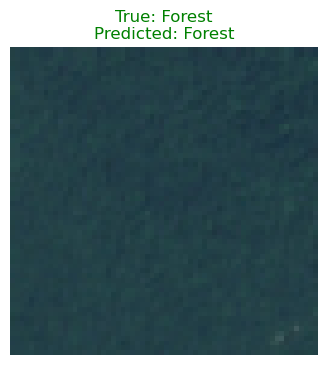

Top predictions:
Forest: 99.96%
SeaLake: 0.03%
HerbaceousVegetation: 0.01%


In [22]:
import matplotlib.pyplot as plt

# --- Visualization code ---
# Get the predicted class name
predicted_class = class_names[class_idx]

# Optionally, get the true class name from the folder structure
true_class = os.path.basename(os.path.dirname(img_path))

correct = (true_class == predicted_class)
title_color = 'green' if correct else 'red'
plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {true_class}\nPredicted: {predicted_class}", color=title_color)
plt.show()

# Optionally, print prediction probabilities for top 3 classes
top_indices = np.argsort(predictions[0])[::-1][:3]
print("Top predictions:")
for i in top_indices:
    print(f"{class_names[i]}: {predictions[0][i]*100:.2f}%")




In [24]:
from PIL import Image

Text(0.5, 1.0, 'True: Forest\nPredicted: Forest (99.96%)')

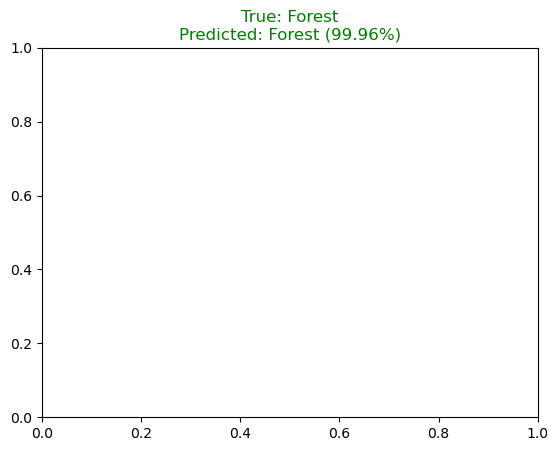

In [23]:
confidence = predictions[0][class_idx] * 100
plt.title(f"True: {true_class}\nPredicted: {predicted_class} ({confidence:.2f}%)", color=title_color)